# Clase SSVEP para acondicionamiento de la señal y plots

Funciones y clase de utilidad para el acondicionamiento y procesamiento de señales de EEG.

## Explicado Clase SSVEP (no correr las celdas)

Importamos funciones de utilidad.

In [ ]:
import numpy as np
import scipy.io as sc
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq
from scipy.signal import butter, filtfilt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

Implemento una función que lea archivo .mat, cree un diccionario con los datos y nos devuelva la key relacionada con la señal de EEG del sujeto.

In [ ]:
def lectorMAT(ruta):
  '''
  Devuelve una matriz de cuatro dimensiones de la forma [estímulos, canales, muestras, trials]
  Hay que ingresar la ruta de donde se encuentra el archivo.mat, debe ser un string del modo 'directorio'
  '''
  Sujeto = sc.loadmat(ruta)
  Sujeto = np.array(Sujeto['eeg'], dtype='float32') #accede a la key 'eeg', convierte los datos adquiridos a una matriz de datos del tipo float32
  Sujeto = Sujeto[:,:,39:,:] #recorta los primeros 39 trial debido a que el sujeto se está preparando
  return Sujeto 

Implemento la clase SSVEP() y su constructor con los atributos necesarios. Los objetos creados mediante esta clase serán una señal única de EEG cruda.

In [ ]:
class SSVEP(): #inicio la clase SSVEP
    
    def __init__(self, ruta, sampleFrec, lowFrec, highFrec, orden, stimuli, trial, utilSamples, estimulos): #constructor
    '''
    Al crear el objeto se deben introducir algunas variables de utilidad que formarán parte de los atributos:
    -ruta: directorio donde se encuentra el archivo .mat, debe ser un string de la forma 'directorio' (copiar y pegar ruta del archivo subido a Colab y agregar comillas)
    -sampleFrec: frecuencia de muestreo del conversor AD
    -lowFrec: frecuencia de corte baja del filtro pasa banda
    -highFrec: frecuencia de corte alta del filtro pasa banda
    -orden: orden del filtro (de 1 a 6). Mientras más alto más pronunciada será la atenuación, pero consumirá más recursos del procesador.
    -stimuli: posición de la frecuencia del estimulador dentro del array en estimulos (primera dimensión de la matriz).
    -trial: número de trial del que queremos la señal de EEG.
    -utilSamples: será el número de muestras que queremos del total de la señal, sirve principalmente para aislar la parte que queremos ver del espectro en frecuencias,
    el máximo de utilSamples será el len() de la señal cruda.
    -estimulos: lista de estimulos para el clasificador de picos
    '''

    self.fm = sampleFrec
    self.Signal = lectorMAT(ruta)
    self.lFrec = lowFrec
    self.hFrec = highFrec
    self.orden = orden
    self.stimuli = stimuli
    self.trial = trial
    self.T = 1/sampleFrec
    self.samples = len(self.Signal[0][0])
    self.totalTime = self.samples/self.fm
    self.utilSamples = utilSamples
    self.Pikes = []
    self.Frecs = []
    self.points = 0
    self.listPoints = []
    self.contador = 0
    self.estimulos = estimulos
    self.accuracy = []
    self.error = 1000
    self.lastStimuli = []

Creamos un método que promediará las señales captadas por cada canal, por lo que nos quedaremos con una sola que será el promedio

In [ ]:
    def meanEEG(self):
      '''
      método que devuelve la señal promediada producto de cada canal. Por lo tanto es necesario que se respete la estructura de matriz de 4 dimensiones
      '''
      self.meanSignal = np.mean(self.Signal[self.stimuli], 0)
      return self.meanSignal

Creamos un método que nos permite graficar la trial de EEG sin acondicionar.  Voltaje en función del tiempo.

In [ ]:
    def plotRawEEG(self):
      self.signal = self.meanEEG()
      self.xAxies = np.arange(0, self.totalTime, self.T)
      plt.plot(self.xAxies, self.signal[:,self.trial])
      plt.title(f'EEG sin filtrar del trial {self.trial} estímulo {self.estimulos[self.stimuli]} Hz')
      plt.xlabel('Tiempo (s)')
      plt.ylabel('Potencia (uV)')

Método que filtra el trial y lo devuelve

In [ ]:
    def filterEEG(self):
      self.signal = self.meanEEG()
      self.frec = 0.5 * self.fm
      self.low = self.lFrec/self.frec
      self.high = self.hFrec/self.frec
      self.b, self.a = butter(self.orden, [self.low, self.high], btype='band')
      self.filterTrial = filtfilt(self.b, self.a, self.signal[:,self.trial])
      return self.filterTrial

Grafica el trial filtrado. Voltaje en función del tiempo.

In [ ]:
    def plotFilterEEG(self):
      self.filterSignal = self.filterEEG()
      self.xAxies = np.arange(0, self.totalTime, self.T)
      plt.plot(self.xAxies, self.filterSignal)
      plt.title(f'EEG filtrado del trial {self.trial} estímulo {self.estimulos[self.stimuli]} Hz')
      plt.xlabel('Tiempo (s)')
      plt.ylabel('Potencia (uV)')

Método que realiza la tranformada rapida de fourier y devuelve los coeficientes de las frecuencias y potencias correspondientes. Recorta los vectores con self.utilSamples dependiendo con que sección del espectro en frecuencias nos queremos quedar

In [ ]:
   def tranformCoeficients(self):
      self.filterSignal = self.filterEEG()
      self.spectrum = fft(self.filterSignal)
      self.frecuencias = np.arange(0, self.fm, self.fm/(len(self.signal)))
      return self.frecuencias[:self.utilSamples], self.spectrum[:self.utilSamples]

Método que grafica su espectro en frecuencias del trial.

In [ ]:
    def plotSpectrum(self):
      self.xAxies, self.yAxies = self.tranformCoeficients()
      plt.plot(self.xAxies, abs(self.yAxies))
      plt.title(f'Espectro de frecuencias del trial {self.trial} estímulo {self.estimulos[self.stimuli]} Hz')
      plt.xlabel('Frecuencia (Hz)')
      plt.ylabel('Potencia(uV)')

# Codigos enteros de las Clases para acondicionamiento de las señales y de clasificación

A partir de aquí es vital ejecutar las celdas para que el codigo funcione correctamente

In [ ]:
import numpy as np
import scipy.io as sc
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq
from scipy.signal import butter, filtfilt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

def lectorMAT(ruta):
  Sujeto = sc.loadmat(ruta)
  Sujeto = np.array(Sujeto['eeg'], dtype='float32')
  Sujeto = Sujeto[:,:,39:,:]
  return Sujeto

class SSVEP():
    
    def __init__(self, ruta, sampleFrec, lowFrec, highFrec, orden, stimuli, trial, utilSamples, estimulos):
      self.fm = sampleFrec
      self.Signal = lectorMAT(ruta)
      self.lFrec = lowFrec
      self.hFrec = highFrec
      self.orden = orden
      self.stimuli = stimuli
      self.trial = trial
      self.T = 1/sampleFrec
      self.samples = len(self.Signal[0][0])
      self.totalTime = self.samples/self.fm
      self.utilSamples = utilSamples
      self.Pikes = []
      self.Frecs = []
      self.points = 0
      self.listPoints = []
      self.contador = 0
      self.estimulos = estimulos
      self.accuracy = []
      self.error = 1000
      self.lastStimuli = []
      self.clf = 0
      
    def meanEEG(self):
      self.meanSignal = np.mean(self.Signal[self.stimuli], 0)
      return self.meanSignal
        
    def plotRawEEG(self):
      self.signal = self.meanEEG()
      self.xAxies = np.arange(0, self.totalTime, self.T)
      plt.plot(self.xAxies, self.signal[:,self.trial])
      plt.title(f'EEG sin filtrar del trial {self.trial} estímulo {self.estimulos[self.stimuli]} Hz')
      plt.xlabel('Tiempo (s)')
      plt.ylabel('Potencia (uV)')

    def filterEEG(self):
      self.signal = self.meanEEG()
      self.frec = 0.5 * self.fm
      self.low = self.lFrec/self.frec
      self.high = self.hFrec/self.frec
      self.b, self.a = butter(self.orden, [self.low, self.high], btype='band')
      self.filterTrial = filtfilt(self.b, self.a, self.signal[:,self.trial])
      return self.filterTrial

    def plotFilterEEG(self):
      self.filterSignal = self.filterEEG()
      self.xAxies = np.arange(0, self.totalTime, self.T)
      plt.plot(self.xAxies, self.filterSignal)
      plt.title(f'EEG filtrado del trial {self.trial} estímulo {self.estimulos[self.stimuli]} Hz')
      plt.xlabel('Tiempo (s)')
      plt.ylabel('Potencia (uV)')

    def tranformCoeficients(self):
      self.filterSignal = self.filterEEG()
      self.spectrum = fft(self.filterSignal)
      self.frecuencias = np.arange(0, self.fm, self.fm/(len(self.signal)))
      return self.frecuencias[:self.utilSamples], self.spectrum[:self.utilSamples]

    def plotSpectrum(self):
      self.xAxies, self.yAxies = self.tranformCoeficients()
      plt.plot(self.xAxies, abs(self.yAxies))
      plt.title(f'Espectro de frecuencias del trial {self.trial} estímulo {self.estimulos[self.stimuli]} Hz')
      plt.xlabel('Frecuencia (Hz)')
      plt.ylabel('Potencia(uV)')

## Prueba de los métodos de la clase SSVEP (no hay necesidad de correrlos)

In [ ]:
directorio = '/content/eeg_s8-eeg_train.mat' #directorio con los datos en colab
fm = 256 #frecuencia de muestreo
lfrec = 7 #frecuencia de corte baja del filtro
hfrec = 45 #frecuencia de corte alta del filtro
orden = 6 #orden del filtro
stimuli = 0 #index del estimulo en la matriz eeg
trial = 0 #index del trial en la matriz eeg
utilSamples = 200 #datos con los que nos queremos quedar en la FFT
estimulos = [9.25, 11.25, 13.25, 9.75, 11.75, 13.75, 10.25, 12.25, 14.25, 10.75, 12.75, 14.75]

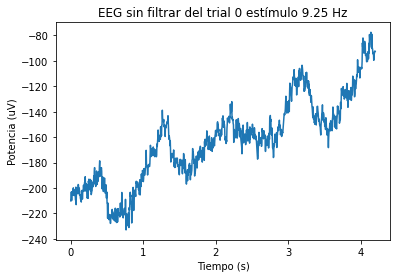

In [ ]:
eeg = SSVEP(directorio, fm, lfrec, hfrec, orden, stimuli, trial, utilSamples, estimulos) #objeto de la clase SSVEP()
eeg.plotRawEEG() #metodo para graficar el trial crudo

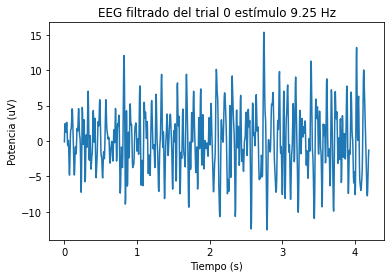

In [ ]:
eeg.plotFilterEEG() #metodo para graficar el trial filtrado

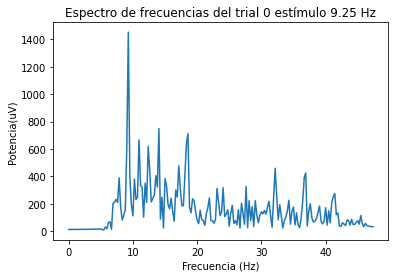

In [ ]:
eeg.plotSpectrum() #metodo para graficar el espectro en frecuencias del trial filtrado

## SVM

Clase y celdas a ejecutar para la clasificación

In [ ]:
class SVM():

  '''
  Clase SVM para la clasificación a través de una suport vector machine del tipo One Vs Rest
  -No se debe ingresar nada
  '''

  def __init_(self): #contructor para almacenar el clasificador
    self.clf = 0

  def train(self, directorioTrain): 
    '''
    Método para entrenar nuestra SVM. Actualmente las features son únicamente la potencia de la FFT, pero se puede añadir también
    las frecuencias correspondientes a las potencias
    -Debe ser ingresado el directorio del archivo con los datos para entrenar (debe ser un .mat).
     Debe ser una matriz de estuctura (clases, canales, muestras, trials)
    '''
    rawSeñal = lectorMAT(directorioTrain) #lee el archivo .mat y lo transforma a una matriz
    clases = len(rawSeñal) #cantidad de clases
    trials = len(rawSeñal[0][0][0]) #cantidad de trials en los datos de entrenamiento

    Potencia = [] #lista vacia para almacenar el componente real de la FFT
    Clase = [] #lista vacia para almacenar las clases del entrenamiento, que a su vez seran las etiquetas de las potencias
    for clase in range(clases):
      for trial in range(trials):
        EEG = SSVEP(directorioTrain, fm, lfrec, hfrec, orden, clase, trial, utilSamples, estimulos) #objeto de la clase SSVEP
        frecuencia, potencia = EEG.tranformCoeficients() #metodo de la clase SSVEP que nos devuelve los compononentes de la potencia
                                                         #de la FFT y el vector correspondiente a las frecuencias del trial n de la clase n
                                                         #en nuestro caso estos serán nuestro features
        Potencia.append(abs(potencia)) #agregamos a la lista potencia el componente real de la potencia de la FFT
        Clase.append(clase) #agregamos las etiquetas, que coinsidirán al INDEX de la frecuencia correspondiente de la lista estimulos

    Potencia = np.array(Potencia) #lista Potencia a narray
    Clase = np.array(Clase) #lista Clase a narray

    self.clf = OneVsRestClassifier(SVC()).fit(Potencia, Clase) #entrena el clasificador con X = Potencia Y = Clase (etiquetas INDEX)
  
  def classify(self, directorioClassif):
    '''
    Método que clasifica la matriz de datos con n trials restantes
    -Debe ser ingresado el directorio del archivo con los datos para entrenar (debe ser un .mat).
     Debe ser una matriz de estuctura (clases, canales, muestras, trials).  
    '''
    rawSeñalC = lectorMAT(directorioClassif) #lee el archivo .mat y lo transforma a una matriz
    clasesC = len(rawSeñalC) #cantidad de clases (debe coincidir con las del entreno)
    trialsC = len(rawSeñalC[0][0][0]) #cantidad de trials a clasificar por clase

    for claseC in range(clasesC):
      print(f'Estímulo {claseC+1}') #imprime un aviso del inicio de la clasificacion de una clase
      for trialC in range(trialsC):
        EEG = SSVEP(directorioClassif, fm, lfrec, hfrec, orden, claseC, trialC, utilSamples, estimulos) #objeto de la clase SSVEP
        frecuencia, potencia = EEG.tranformCoeficients() #metodo de la clase SSVEP que nos devuelve los compononentes de la potencia
                                                         #de la FFT y el vector correspondiente a las frecuencias del trial n de la clase n
                                                         #en nuestro caso estos serán nuestro features

        test = np.array([abs(potencia)]) #features potencia convertido a array
        predict = self.clf.predict(test) #clasifica el trial n correspondiente a la clase en cuestion por el bucle for
        print(f'Trial {trialC+1}: {estimulos[predict[0]]} Hz') #Imprime la predicción para el trial en cuestion

        #Recordar que etiquetamos los datos a partir del INDEX de la lista estimulos, por lo que para saber a que 
        #frecuencia corresponde la clasificacion hay que consultar a que frecuencuencia corresponde el INDEX en la lista estimulos

En la siguiente celda se ejecutará el entrenamiento y clasificación de los datos SSVEPs correspondientes a la consigna.

Solo se deben ingresar los directorios correspondientes a los datos de entrenamiento y clasificación. Evitar tocar los otros valores y Run.

In [ ]:
directorioTrain = '' #aqui se debe ingresar entre las comillas el directorio del archivo .mat correspondiente a los datos para 
                     #entrenar nuestra SVM
directorioClasificacion = '' #aqui se debe ingresar entre las comillas el directorio del archivo .mat correspondiente a los datos a
                              #clasificar
fm = 256 #frecuencia de muestreo. NO TOCAR
lfrec = 7 #frecuencia de corte baja para el filtro. NO TOCAR
hfrec = 45 #frecuencia de corte alta para el filtro. NO TOCAR
orden = 6 #orden del filtro. NO TOCAR
utilSamples = 200 #muestras utiles para la FFT. NO TOCAR
estimulos = [9.25, 11.25, 13.25, 9.75, 11.75, 13.75, 10.25, 12.25, 14.25, 10.75, 12.75, 14.75] #lista con las frecuencias de los estímulos
#NO TOCAR

suportVectomashin = SVM() #objeto de nuestra clase SVM()
suportVectomashin.train(directorioTrain) #método para entrenar a partir de los datos
suportVectomashin.classify(directorioClasificacion) #metodo que clasifica los datos